In [1]:
import os
import numpy as np
import tensorflow as tf
from alexnet import AlexNet
import picar
import random
from PIL import Image

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Path to the textfiles for the trainings and validation set
image_file = 'train.txt'
batch_size = 1
num_classes = 6
train_layers = ['fc8', 'fc7', 'fc6']

IMAGENET_MEAN = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32)

# How often we want to write the tf.summary data to disk
display_step = 100

# Path for tf.summary.FileWriter and to store model checkpoints
filewriter_path = "tmp/finetune_alexnet/tensorboard"
checkpoint_path = "tmp/finetune_alexnet/checkpoints"
#checkpoint_file = None
#checkpoint_file = "tmp/finetune_alexnet/checkpoints/model_epoch1012.ckpt"

train_txt = "./train.txt"
dev_txt = "./dev.txt"
test_txt = "./test.txt"

testPath = "./test"

classes = ["B","R","SR","F","SL","L"]

In [2]:
# TF placeholder for graph input and output
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
y = tf.placeholder(tf.float32, [batch_size, num_classes])
keep_prob = tf.placeholder(tf.float32)

# Initialize model
model = AlexNet(x, keep_prob, num_classes, train_layers)

# Link variable to model output
score = model.fc8

pred = tf.argmax(score, 1)

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

In [3]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

# Load the pretrained weights into the non-trainable layer
#if not checkpoint_file:
model.load_initial_weights(sess)

# Restore checkpoint
if checkpoint_path:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

INFO:tensorflow:Restoring parameters from tmp/finetune_alexnet/checkpoints/model.ckpt-4048


['./test/frame_2017-07-25T21-00-04Z_788.png', '2']
[[[ 13  29  13]
  [ 12  28  12]
  [ 13  29  13]
  ...
  [121 115 117]
  [123 114 120]
  [121 112 118]]

 [[ 14  30  14]
  [ 14  30  14]
  [ 11  27  11]
  ...
  [146 140 142]
  [192 183 189]
  [202 193 199]]

 [[ 13  28  11]
  [ 14  29  12]
  [ 15  33  12]
  ...
  [252 249 250]
  [252 248 251]
  [252 248 251]]

 ...

 [[  3  25   0]
  [  4  26   0]
  [ 11  30   6]
  ...
  [ 24  32  30]
  [ 24  29  23]
  [ 25  30  24]]

 [[  5  27   0]
  [  6  28   1]
  [ 11  30   6]
  ...
  [ 20  28  26]
  [ 27  32  26]
  [ 26  31  25]]

 [[  9  28   4]
  [  9  28   4]
  [  8  28   1]
  ...
  [ 16  22  20]
  [ 25  30  24]
  [ 28  33  27]]]
[2]


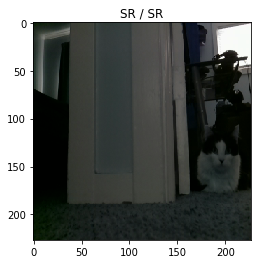

In [5]:
#image = picar.getRandomImageFromText(test_txt)
image = ["./test/frame_2017-07-25T21-00-04Z_788.png", "2"]
print(image)

# load and preprocess the image
img_string = tf.read_file(image[0])
img_decoded = tf.image.decode_png(img_string, channels=3)

result = sess.run(img_decoded)
print(result)

img_resized = tf.image.resize_images(img_decoded, [227, 227])
img_centered = tf.subtract(img_resized, IMAGENET_MEAN)
img_bgr = tf.reverse(img_centered, axis=[-1])
batch = tf.expand_dims(img_bgr, 0)   
input_image = sess.run(batch)

result = sess.run(pred, feed_dict={x: input_image, keep_prob: 1.})
print(result)

plt.title(classes[int(result)] + " / " + classes[int(image[1])])
plt.imshow(Image.open(image[0]))   


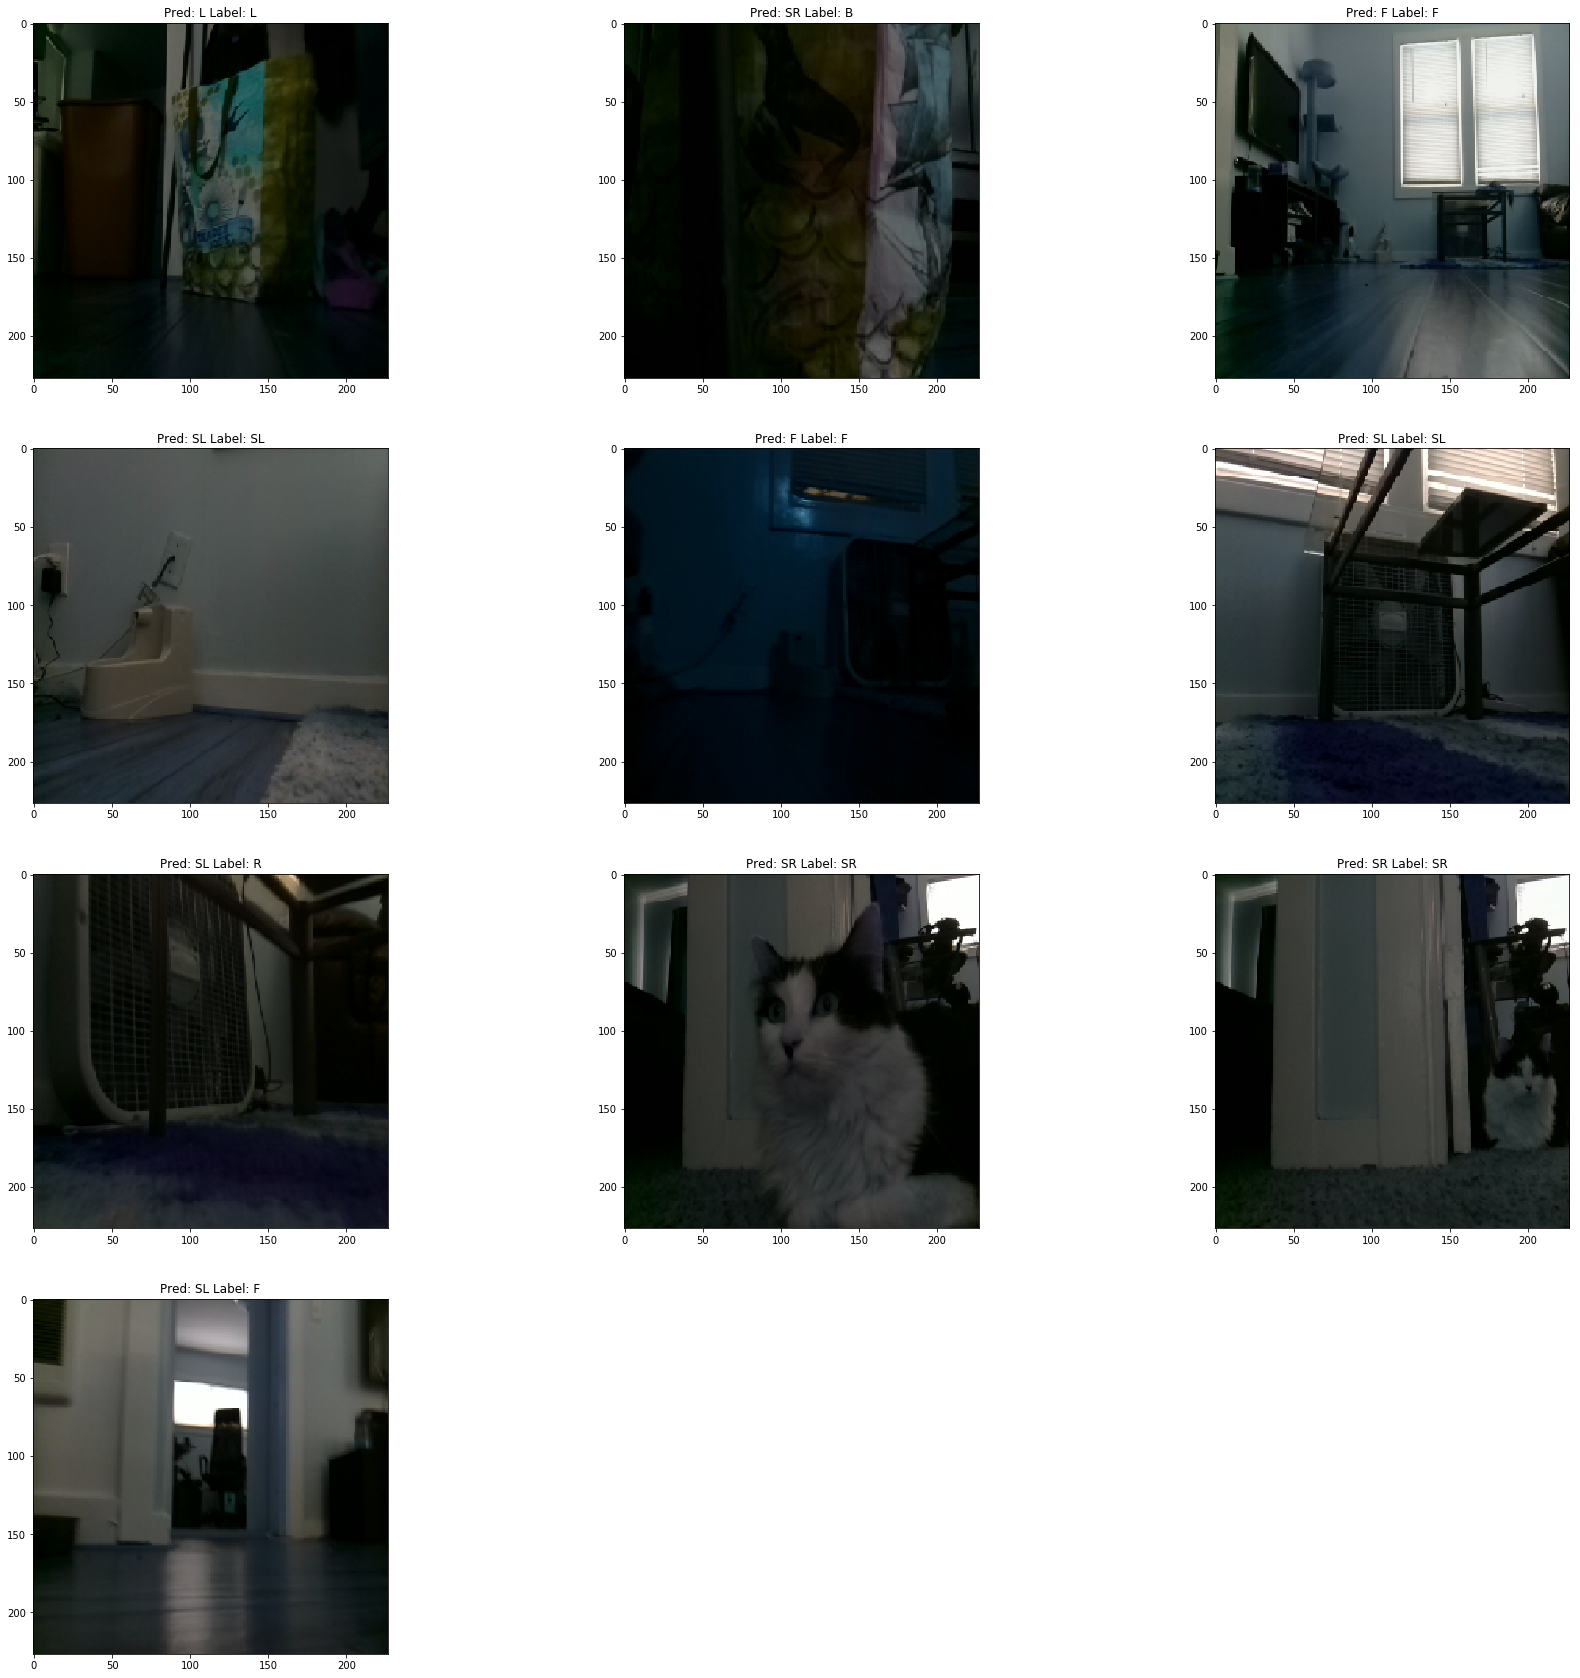

In [10]:
images = [];
for i in range(10):
    images.append(picar.getRandomImageFromText(test_txt))

columns = 3
plt.figure(figsize=(30,30))


for i, image in enumerate(images):
    # load and preprocess the image
    img_string = tf.read_file(image[0])
    img_decoded = tf.image.decode_png(img_string, channels=3)
    img_resized = tf.image.resize_images(img_decoded, [227, 227])
    img_centered = tf.subtract(img_resized, IMAGENET_MEAN)
    # RGB -> BGR
    img_bgr = img_centered[:, :, ::-1]    
    input_image = sess.run(img_bgr)
    result = sess.run(pred, feed_dict={x: [input_image], keep_prob: 1.})
    
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title("Pred: " + classes[int(result)] + " Label: " + classes[int(image[1])])
    plt.imshow(Image.open(image[0]))   

In [6]:
tf.train.write_graph(sess.graph, "./", "graph.pb")

'./graph.pb'

In [9]:
tf.saved_model.simple_save(sess, "./models", {"input": x}, {"pred": pred})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./models/saved_model.pb'
